<a href="https://colab.research.google.com/github/ABDNerwat/PINN-practice/blob/main/Non_homogenous_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install sciann

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 KB 24.4 MB/s eta 0:00:00


In [4]:
import sciann as sn
import numpy as np
import matplotlib.pyplot as plt

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.11.0 
Python Version: 3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0] 



In [5]:
from itertools import cycle
cycol = cycle('bgrcmk')
class DataGeneratorXY:
  """ Generates 2D collocation grid for a rectangular domain
  # Arguments:
    X: [X0, X1]
    Y: [Y0, Y1]
    targets: list and type of targets you wish to impose on PINNs. 
        ('domain', 'bc-left', 'bc-right', 'bc-bot', 'bc-top', 'all')
    num_sample: total number of collocation points. 
  # Examples: 
    >> dg = DataGeneratorXY([0., 1.], [0., 1.], ["domain", "bc-left", "bc-right"], 10000)
    >> input_data, target_data = dg.get_data()
  """
  def __init__(self, 
               X=[0., 1.],
               Y=[0., 1.],
               targets=['domain', 'bc-left', 'bc-right', 'bc-bot', 'bc-top'], 
               num_sample=10000):
    'Initialization'
    self.Xdomain = X
    self.Ydomain = Y
    self.targets = targets
    self.num_sample = num_sample
    self.input_data = None
    self.target_data = None
    self.set_data()

  def __len__(self):
    return self.input_data[0].shape[0]

  def set_data(self):
    self.input_data, self.target_data = self.generate_data()

  def get_data(self):
    return self.input_data, self.target_data

  def generate_data(self):
    # distribute half inside domain half on the boundary 
    num_sample = int(self.num_sample/2)
    
    counter = 0
    # domain points 
    x_dom = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample)
    y_dom = np.random.uniform(self.Ydomain[0], self.Ydomain[1], num_sample)
    ids_dom = np.arange(x_dom.shape[0])
    counter += ids_dom.size

    # bc points 
    num_sample_per_edge = int(num_sample/4)
    # left bc points 
    x_bc_left = np.full(num_sample_per_edge, self.Xdomain[0])
    y_bc_left = np.random.uniform(self.Ydomain[0], self.Ydomain[1], num_sample_per_edge)
    ids_bc_left = np.arange(x_bc_left.shape[0]) + counter
    counter += ids_bc_left.size

    # right bc points 
    x_bc_right = np.full(num_sample_per_edge, self.Xdomain[1])
    y_bc_right = np.random.uniform(self.Ydomain[0], self.Ydomain[1], num_sample_per_edge)
    ids_bc_right = np.arange(x_bc_right.shape[0]) + counter 
    counter += ids_bc_right.size

    # bot bc points 
    x_bc_bot = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample_per_edge)
    y_bc_bot = np.full(num_sample_per_edge, self.Ydomain[0])
    ids_bc_bot = np.arange(x_bc_bot.shape[0]) + counter
    counter += ids_bc_bot.size

    # right bc points 
    x_bc_top = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample-num_sample_per_edge)
    y_bc_top = np.full(num_sample-num_sample_per_edge, self.Ydomain[1])
    ids_bc_top = np.arange(x_bc_top.shape[0]) + counter
    counter += ids_bc_top.size

    ids_bc = np.concatenate([ids_bc_left, ids_bc_right, ids_bc_bot, ids_bc_top])
    ids_all = np.concatenate([ids_dom, ids_bc])

    ids = {
        'domain': ids_dom, 
        'bc-left': ids_bc_left, 
        'bc-right': ids_bc_right,
        'bc-bot': ids_bc_bot,
        'bc-top': ids_bc_top,
        'bc': ids_bc,
        'all': ids_all
    }

    assert all([t in ids.keys() for t in self.targets]), \
      'accepted target types: {}'.format(ids.keys())

    input_data = [
        np.concatenate([x_dom, x_bc_left, x_bc_right, x_bc_bot, x_bc_top]).reshape(-1,1),
        np.concatenate([y_dom, y_bc_left, y_bc_right, y_bc_bot, y_bc_top]).reshape(-1,1),
    ]
    total_sample = input_data[0].shape[0]

    target_data = []
    for i, tp in enumerate(self.targets):
      target_data.append(
          (ids[tp], 'zeros')
      )
      
    return input_data, target_data

  def get_test_grid(self, Nx=200, Ny=200):
    xs = np.linspace(self.Xdomain[0], self.Xdomain[1], Nx)
    ys = np.linspace(self.Ydomain[0], self.Ydomain[1], Ny)
    input_data, target_data = np.meshgrid(xs, ys)
    return [input_data, target_data]

  def plot_sample_batch(self, batch_size=500):
      ids = np.random.choice(len(self), batch_size, replace=False)
      x_data = self.input_data[0][ids,:]
      y_data = self.input_data[1][ids,:]
      plt.scatter(x_data, y_data)
      plt.xlabel('x')
      plt.ylabel('y')
      plt.title('Sample batch = {}'.format(batch_size))
      plt.show()

  def plot_data(self):
      fig = plt.figure()
      for t, (t_idx, t_val) in zip(self.targets, self.target_data):
        x_data = self.input_data[0][t_idx,:]
        y_data = self.input_data[1][t_idx,:]
        plt.scatter(x_data, y_data, label=t, c=next(cycol))
      plt.xlabel('x')
      plt.ylabel('y')
      plt.legend(title="Training Data", bbox_to_anchor=(1.05, 1), loc='upper left')
      fig.tight_layout()
      plt.show()


In [16]:
dtype = 'float32'
x = sn.Variable("x", dtype = dtype)
y = sn.Variable("y", dtype = dtype)

Ux = sn.Functional("Ux", [x,y], 4*[64], 'tanh')
Uy = sn.Functional("Uy", [x,y], 4*[64], 'tanh')
Sxx = sn.Functional("Sxx", [x,y], 4*[64], 'tanh')
Sxy = sn.Functional("Sxy", [x,y], 4*[64], 'tanh')
Syy = sn.Functional("Syy", [x,y], 4*[64], 'tanh')
lmbd = sn.Functional("lmbd", [x,y], 4*[64], 'tanh')

L1 = sn.diff(Sxx,x) + sn.diff(Sxy,y)
L2 = sn.diff(Sxy,x) + sn.diff(Syy,y) 
L3 = lmbd*(sn.diff(Ux,x) + sn.diff(Uy,y)) + 0.5*lmbd*(sn.diff(Ux,x)) - Sxx
L4 = lmbd*(sn.diff(Ux,x) + sn.diff(Uy,y)) + 0.5*lmbd*(sn.diff(Uy,y)) - Syy
L5 = 0.25*lmbd*(sn.diff(Ux,y) + sn.diff(Uy,x)) - Sxy

BC_top_1 = (y==1)*(Syy)
BC_top_2 = (y==1)*(Sxy)
BC_bot_1 = (y==-1)*(Uy)
BC_bot_2 = (y==-1)*(Sxy)
BC_left_1 = (x==-1)*(Ux)
BC_left_2 = (x==-1)*(Sxy)
BC_right_1 = (x==1)*(Sxy)
BC_right_2 = (x==1)*(Sxx - 2.5e-5)
BC_1 = ((x**2 + y**2)**0.5 < 0.25)*(lmbd - 14.285) + ((x**2 + y**2)**0.5 >= 0.25)*(lmbd - 2.1428)

targets = [L1,L2,L3,L4,L5,BC_1,BC_top_1,BC_top_2,BC_bot_1,BC_bot_2,BC_left_1,BC_left_2,BC_right_1,BC_right_2]

In [17]:
dg = DataGeneratorXY(X=[-1.,1.], Y=[-1.,1.], 
                     num_sample=10000,
                     targets=6*['domain'] + 2*['bc-left'] + 2*['bc-right'] + 2*['bc-bot'] + 2*['bc-top'])

input_data, target_data = dg.get_data()

In [18]:
m = sn.SciModel([x, y], targets)
m.train(input_data, target_data, batch_size=100, epochs=300)


Total samples: 12500 
Batch size: 100 
Total batches: 125 

Epoch 1/300
125/125 [==============================] - 9s 32ms/step - batch: 62.0000 - size: 100.0000 - loss: 6.3491 - add_18_loss: 0.0236 - add_19_loss: 0.0092 - sub_12_loss: 0.0570 - sub_13_loss: 0.0658 - sub_14_loss: 0.0101 - add_27_loss: 6.1834 - mul_43_loss: 0.0000e+00 - mul_44_loss: 0.0000e+00 - mul_45_loss: 0.0000e+00 - mul_46_loss: 0.0000e+00 - mul_47_loss: 0.0000e+00 - mul_48_loss: 0.0000e+00 - mul_49_loss: 0.0000e+00 - mul_50_loss: 0.0000e+00 - lr: 0.0010 - time: 9.0084
Epoch 2/300
125/125 [==============================] - 3s 23ms/step - batch: 62.0000 - size: 100.0000 - loss: 3.8164 - add_18_loss: 0.0012 - add_19_loss: 0.0017 - sub_12_loss: 0.3810 - sub_13_loss: 0.4031 - sub_14_loss: 0.0063 - add_27_loss: 3.0231 - mul_43_loss: 0.0000e+00 - mul_44_loss: 0.0000e+00 - mul_45_loss: 0.0000e+00 - mul_46_loss: 0.0000e+00 - mul_47_loss: 0.0000e+00 - mul_48_loss: 0.0000e+00 - mul_49_loss: 0.0000e+00 - mul_50_loss: 0.0000e+

In [19]:
x_test, y_test = np.meshgrid(np.linspace(-1,1,200), np.linspace(-1,1,200))
u_test = Ux.eval([x_test, y_test])
v_test = Uy.eval([x_test, y_test])
sxx_test = Sxx.eval([x_test, y_test])
syy_test = Syy.eval([x_test, y_test])
sxy_test = Sxy.eval([x_test, y_test])

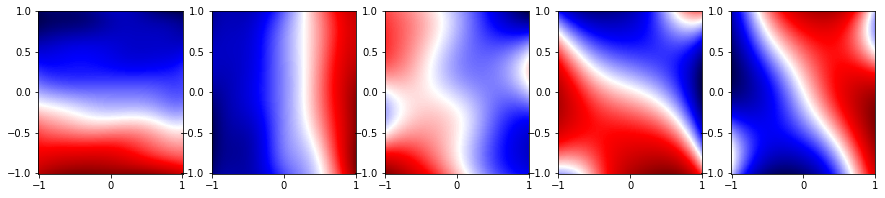

In [20]:
fig,ax = plt.subplots(1,5,figsize=(15,3))
ax[0].pcolor(x_test, y_test, u_test, cmap='seismic', shading='auto')
ax[1].pcolor(x_test, y_test, v_test, cmap='seismic', shading='auto')
ax[2].pcolor(x_test, y_test, sxx_test, cmap='seismic', shading='auto')
ax[3].pcolor(x_test, y_test, syy_test, cmap='seismic', shading='auto')
ax[4].pcolor(x_test, y_test, sxy_test, cmap='seismic', shading='auto')
plt.show()